In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate, constants
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
import platform


In [2]:
# Data load and pre-processing
version = 'v20221104'
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute\\"
#oscar_path = "D:\\data\\oscar\\v20221104\\matlab-pre-processed\\"

file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

# Match tracks in the star pattern from track names and times in the DAR_v6.0 to file aquisition times
star_pattern_tracks={
    'Track_L1' : 0,
    'Track_1a' : 1,
    'Track_2a' : 2,
    'Track_1b' : 3,
    'Track_11' : 4,
    'Track_12' : 5,
    'Track_13' : 6,
    'Track_14' : 7,
    'Track_15' : 8,
    'Track_16' : 9,
    'Track_17' : 10,
    'Track_18' : 11}
# L1a variables to be passed to L1b dataset
vars_to_keep = [
        'LatImage',
        'LonImage',
        'IncidenceAngleImage',
        'SquintImage',
        ]
# Compute L1C - Sigma0 + RVL
ds_L1b = dict()

# Loop through star pattern tracks
for track in star_pattern_tracks.keys():
    ds_ml = dict()
    file_index = star_pattern_tracks[track]
    ds_L1a = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    print('Processing file index',file_index)
    
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_L1a[dict_index],
                                                         ds_ml[dict_index])
   
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
    #-----------------------------------------------------------
    ds_ml = ss.oscar.level1.fill_missing_variables(ds_ml, antenna_ident)
    
    # Build L1b dataset
    ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
    del ds_ml


OSCAR L1 processing - version v20221104
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\May22_full_precompute\
-------------------
File index : 0 , Aquisition time : 20220522T052218 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220522T053942 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220522T054805 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220522T055458 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220522T062018 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220522T062620 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220522T063239 , File list indices : [18, 19, 20]
File index : 7 , Aquisition time : 20220522T063906 , File list indices : [21, 22, 23]
File index : 8 , Aquisition time : 20220522T064459 , File list indices : [24, 25, 26]
File index : 9 , Aquisition time : 20220522T065108 , File list indices :

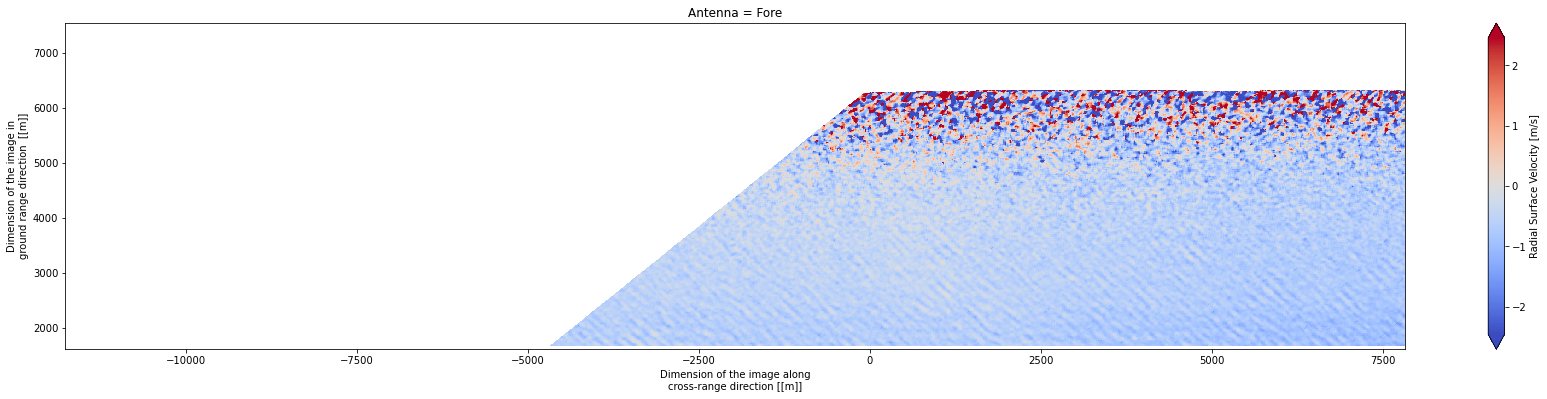

In [3]:
ax2 = ds_L1b['Track_13'].RadialSurfaceVelocity.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='coolwarm',

                                                                       )